In [1]:
import pickle
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from datetime import timedelta
from sklearn.metrics import mean_squared_error


df = pd.read_csv('../data/flu_data_7.csv')
df['date'] = pd.to_datetime(df['date'])

df_new = df
data = df_new.sort_values("date").reset_index(drop=True)

In [2]:
dates = data['date'].iloc[11:]
time_steps = 9
# 创建存储结果的列表
results = []

# 预测基线（预测未来8周）
for i in range(len(dates)-9):
    current_date = dates.iloc[i+1]
    current_ILI = data['ILI+'].iloc[11+i]
    
    # 创建字典存储当前结果
    result = {
        'date': current_date,
        'week_ahead0': current_ILI,
        'week_ahead1': current_ILI,
        'week_ahead2': current_ILI,
        'week_ahead3': current_ILI,
        'week_ahead4': current_ILI,
        'week_ahead5': current_ILI,
        'week_ahead6': current_ILI,
        'week_ahead7': current_ILI,
        'week_ahead8': current_ILI
    }
    
    results.append(result)

# 转换为DataFrame
results_df = pd.DataFrame(results)


In [3]:
result_dfs = []
for i in range(time_steps):
    temp_df = pd.DataFrame({
        'date': results_df['date'] + timedelta(days=i * 7),
        'week_ahead': i,  # 第1周、第2周...
        'point': results_df[f'week_ahead{i}'],
        'mode' : 'train'
    })
    result_dfs.append(temp_df)
    
final_pred_df = pd.concat(result_dfs, ignore_index=True)

true_df = data[['date',"ILI+"]]

format_pred_df = pd.merge(
    final_pred_df,       # 左表（预测值）
    true_df,             # 右表（真实值）
    on='date',           # 连接键
    how='left')
format_pred_df = format_pred_df.rename(columns={'ILI+': 'true'})
quantiles = [0.01,0.025,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,0.975,0.99]
from scipy.stats import beta

def calc_quantiles(row, k=220, quantiles= [0.01,0.025,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,0.975,0.99]  # 定义分位数列表
):
    t = row['week_ahead']
    k = k-15*(t+1)
    if row['point']<=0:
        row['point']=1e-3
    scale = (row['point'] / 100)
    a = k * scale
    b = k * (1 - scale)
    quant_values = beta.ppf(quantiles, a, b)
    quant_values =quant_values*100
    return pd.Series(quant_values, index=[f'q_{int(q*100)}' for q in quantiles])

# 动态生成列名并赋值
result_cols = [f'q_{int(q*100)}' for q in quantiles]

format_pred_df[result_cols] = format_pred_df.apply(calc_quantiles, axis=1)

format_pred_df.to_csv('../res/forc_baseline.csv', index=False)

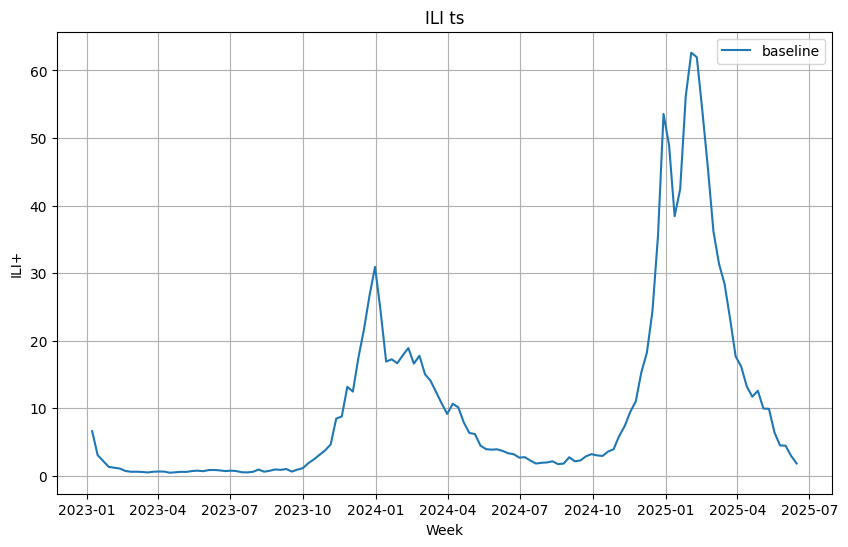

In [4]:
import matplotlib.pyplot as plt

data_covid = data[data['date']>'2023-01-01']

plt.figure(figsize=(10, 6))
plt.plot(data_covid['date'], data_covid['ILI+'], label='baseline', alpha=1)
plt.xlabel('Week')
plt.ylabel('ILI+')
plt.title('ILI ts')
plt.legend()
plt.grid(True)

plt.show()